In [38]:
import pandas as pd

casting_df = pd.read_csv('data/robocasting_dataset.csv')
casting_df.columns = casting_df.iloc[0]
casting_df = casting_df[1:].reset_index(drop=True)
casting_df = casting_df.iloc[2:31]

casting_df.head()

,number,date,height_1,height_2,height_3,width_1,width_2,width_3,temp,bed_temp,humidity,layer_count,slicer_layer_height,slicer_layer_width,slicer_nozzle_speed,slicer_extrusion_multiplier
2,3,31.10.2024,"0,65","0,75","0,82","1,75","1,96","1,75","18,5",NaN,41%,1,0.8,1.5,10,1
3,4,31.10.2024,"0,78","0,87","0,84","2,21","1,77","2,14","18,5",NaN,41%,1,0.8,1.5,10,1
4,5,31.10.2024,"0,86","0,78","0,89","1,96","1,85","1,93","18,5",NaN,41%,1,0.8,1.5,10,1
5,6,31.10.2024,"0,85","0,86","0,98","2,17","1,93","1,9","18,5",NaN,41%,1,0.8,1.5,10,1
6,7,31.10.2024,"0,81","0,94","0,91","2,25","2,05","2,07","18,5",NaN,41%,1,0.8,1.5,10,1


In [39]:
casting_df.drop(columns=['bed_temp', 'date', 'number',
                         'humidity', 'layer_count'], inplace=True)

# Replace commas with dots and convert to float
casting_df = casting_df.map(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else float(x))

casting_df.head()

,height_1,height_2,height_3,width_1,width_2,width_3,temp,slicer_layer_height,slicer_layer_width,slicer_nozzle_speed,slicer_extrusion_multiplier
2,0.65,0.75,0.82,1.75,1.96,1.75,18.5,0.8,1.5,10.0,1.0
3,0.78,0.87,0.84,2.21,1.77,2.14,18.5,0.8,1.5,10.0,1.0
4,0.86,0.78,0.89,1.96,1.85,1.93,18.5,0.8,1.5,10.0,1.0
5,0.85,0.86,0.98,2.17,1.93,1.90,18.5,0.8,1.5,10.0,1.0
6,0.81,0.94,0.91,2.25,2.05,2.07,18.5,0.8,1.5,10.0,1.0


In [40]:
# Calculate average values for height and width
casting_df['height_average'] = casting_df['height_1'] + casting_df['height_2'] + casting_df['height_3']
casting_df['width_average'] = casting_df['width_1'] + casting_df['width_2'] + casting_df['width_3']

# Calculate average difference values for height and width
casting_df['avg_height_diff'] = abs(casting_df['height_average']-casting_df['slicer_layer_height'])
casting_df['avg_width_diff'] = abs(casting_df['width_average']-casting_df['slicer_layer_width'])
casting_df['avg_diff'] = (casting_df['avg_height_diff']+casting_df['avg_width_diff'])/2

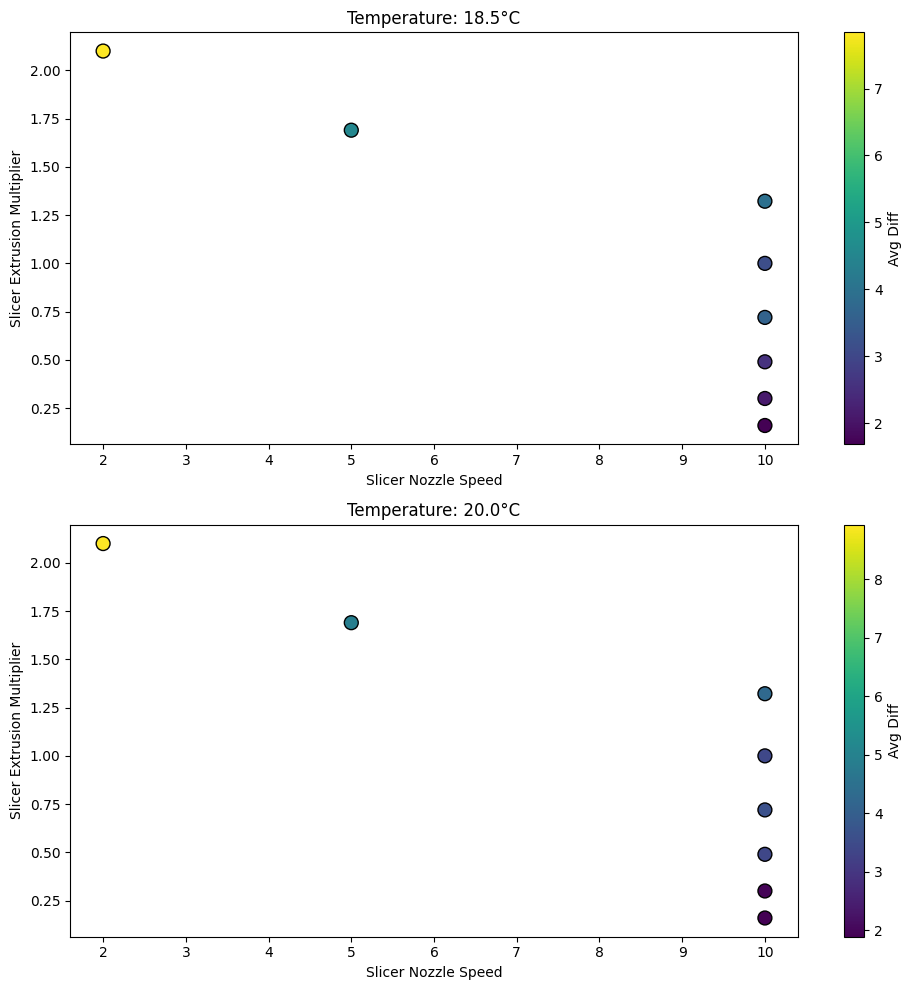

In [41]:
import matplotlib.pyplot as plt

# Group by 'temp', 'slicer_nozzle_speed', and 'slicer_extrusion_multiplier', taking the mean of 'avg_diff'
avg_diff_df = casting_df.groupby(['temp', 'slicer_nozzle_speed', 'slicer_extrusion_multiplier'], as_index=False).mean()

# Get unique temperatures
unique_temps = avg_diff_df['temp'].unique()

# Set up the plot grid
plt.figure(figsize=(10, 5 * len(unique_temps)))

# Create a plot for each unique temp value
for i, temp in enumerate(unique_temps, start=1):
    plt.subplot(len(unique_temps), 1, i)
    
    # Filter DataFrame for the current temp
    temp_df = avg_diff_df[avg_diff_df['temp'] == temp]
    
    # Create scatter plot with color based on 'avg_diff'
    scatter = plt.scatter(
        x=temp_df['slicer_nozzle_speed'],
        y=temp_df['slicer_extrusion_multiplier'],
        c=temp_df['avg_diff'],
        cmap='viridis',
        edgecolor='k',
        s=100
    )
    
    # Set plot title and labels
    plt.title(f'Temperature: {temp}°C')
    plt.xlabel('Slicer Nozzle Speed')
    plt.ylabel('Slicer Extrusion Multiplier')
    
    # Add color bar for 'avg_diff' values
    cbar = plt.colorbar(scatter)
    cbar.set_label('Avg Diff')

# Adjust layout
plt.tight_layout()
plt.show()
